<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/7.0.3-biGRU16-GloVe-2m-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained embedding using GRU

In this notebook, we will train a biGRU network with 1 million samples.

Architecture is the same as previous notebook:

* Embedding: GloVe
* Class Weights: balanced
* Bidirectional GRU Units: 16
* Dropout: None

# Result

Previous score with 1mil entries: 0.29134436633997374

Our score is: 0.3070458781836454

We seem to be plateauing after 500k samples in this architecture




In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 2.x selected.


'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


GRU_DIM = 16 # total LSTM units
MODEL_NAME = f"biGRU{GRU_DIM}"
ARCHITECTURE = f"1x{GRU_DIM}"
DESCRIPTION = f"1 Layer {GRU_DIM} GRU Units, No Dropout, GloVe Embedding, Balanced Weights"
FEATURE_SET_NAME = "glove"
PATIENCE = 4

SAMPLES = "2m"

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
  ku.ModelWrapper.set_report_filename('test-dl_prototype-report.csv')
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-preprocessed.csv"
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename('glove_embedding-dl_prototype-report.csv')


EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'

# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100




In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

In [4]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer(oov_token="<UNK>")
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=164816
Number of Documents=1500000
Train review vectors shape: (1500000, 100)  Test review vectors shape: (500000, 100)


## Load our pre-trained embedding

embeddings_index will be a map where key == word, value == the embedding vector

In [5]:
print('Indexing word vectors.')

embeddings_index = {}
with open(EMBEDDING_FILE) as f:
    print(f'Opened file: {EMBEDDING_FILE}')
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Opened file: drive/My Drive/Springboard/capstone/data/embeddings/glove.840B.300d.txt
Found 2195884 word vectors.


## Create Embedding Matrix based on our tokenizer

For every word in our vocabulary, we will look up the embedding vector and add the it to our embedding matrix

The matrix will be passed in as weights in our embedding layer later

If there is word that does not exist in the pre-trained embedding vocabulary, we will leave the weights as 0 vector and save off the word into a CSV file later for analysis

In [6]:
# this is a map with key == word, value == index in the vocabulary
word_index = t.word_index
print(f'word_index length: {len(word_index)}')

# we are going to use the entire vocab so we can alter this from the example
# num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

# start with a matrix of 0's
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

# if a word doesn't exist in our vocabulary, let's save it off
missing_words = []
print(f'embedding_matrix shape: {np.shape(embedding_matrix)}')
for word, i in word_index.items():
    # print(f'word: {word} i: {i}')
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and np.shape(embedding_vector)[0] == EMBED_SIZE:
        # words not found in embedding index will be all-zeros.
        # print(f'i: {i} embedding_vector shape: {np.shape(embedding_vector)}')
        embedding_matrix[i] = embedding_vector
    else:
      missing_words.append(word)

print(f'Number of missing words from our vocabulary: {len(missing_words)}')



word_index length: 164817
embedding_matrix shape: (164818, 300)
Number of missing words from our vocabulary: 84541


Save off our missing words into a csv file so we can analyze this later

In [0]:
# save missing words into a file so we can analyze it later
missing_words_df = pd.DataFrame(missing_words)
missing_words_df.to_csv(MISSING_WORDS_FILE, index=False)

**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_index)+1

# building our network
model = Sequential()
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
model.add(Embedding(input_dim=vocab_size,
                            output_dim=EMBED_SIZE,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
model.add(Bidirectional(GRU(units=GRU_DIM)))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          49445400  
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                30528     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 49,476,093
Trainable params: 30,693
Non-trainable params: 49,445,400
_________________________________________________________________
None


In [10]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              patience=2,
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.42593345 3.00543985 2.2162261  1.19794911 0.37313468]
Number of training examples: 1500000
Train on 1200000 samples, validate on 300000 samples
Epoch 1/50
1200000/1200000 [==============================] - 166s 138us/sample - loss: 0.8233 - categorical_accuracy: 0.6794 - val_loss: 0.7806 - val_categorical_accuracy: 0.6933
Epoch 2/50
1200000/1200000 [==============================] - 156s 130us/sample - loss: 0.7736 - categorical_accuracy: 0.6972 - val_loss: 0.7677 - val_categorical_accuracy: 0.6985
Epoch 3/50
1200000/1200000 [==============================] - 154s 128us/sample - loss: 0.7623 - categorical_accuracy: 0.7013 - val_loss: 0.7604 - val_categorical_accuracy: 0.7012
Epoch 4/50
1200000/1200000 [==============================] - 151s 126us/sample - loss: 0.7553 - categorical_accuracy: 0.7044 - val_loss: 0.7610 - val_categorical_accuracy: 0.7019
Epoch 5/50
1200000/1200000 [==============================] - 148s 123us/sample - loss: 0.7504 - categorical_accuracy:

Number of test: 500000
Running model.evaluate...
500000/500000 [==============================] - 105s 211us/sample - loss: 0.7442 - categorical_accuracy: 0.7087
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(500000, 5)
Getting classification report...
Accuracy: 70.87%


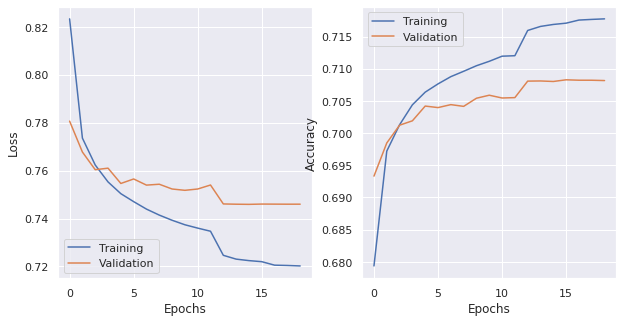


Confusion Matrix
[[ 58921   3101   3974    712   3572]
 [ 16129   4358   8087   1502   3147]
 [  7650   3056  16157   8341   9762]
 [  2280    664   7787  24322  48285]
 [  2906    325   3064  11319 250579]]

Classification Report
              precision    recall  f1-score   support

           1       0.67      0.84      0.75     70280
           2       0.38      0.13      0.19     33223
           3       0.41      0.36      0.38     44966
           4       0.53      0.29      0.38     83338
           5       0.79      0.93      0.86    268193

    accuracy                           0.71    500000
   macro avg       0.56      0.51      0.51    500000
weighted avg       0.67      0.71      0.68    500000



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

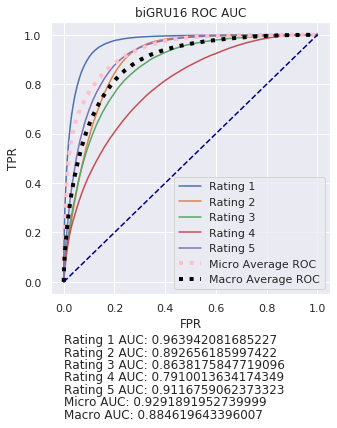

In [11]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [12]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.3070458781836454


**Save off various files**

In [0]:
mw.save(DRIVE_DIR, append_report=True)

description: biGRU16-1x16-glove-sampling_none-2000000-100-star_rating
Saving to report file: drive/My Drive/Springboard/capstone/reports/glove_embedding-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/glove_embedding-dl_prototype-report.csv
{'model_name': 'biGRU16', 'architecture': '1x16', 'description': '1 Layer 16 GRU Units, No Dropout, GloVe Embedding, Balanced Weights', 'classification_report': '{"1": {"precision": 0.6704253237148123, "recall": 0.8383750711439955, "f1-score": 0.7450526661861587, "support": 70280}, "2": {"precision": 0.37882475660639775, "recall": 0.13117418655750535, "f1-score": 0.1948711069376439, "support": 33223}, "3": {"precision": 0.4135503852159001, "recall": 0.35931592758973446, "f1-score": 0.3845302552507884, "support": 44966}, "4": {"precision": 0.526495800502208, "recall": 0.29184765653123423, "f1-score": 0.37553074868374325, "support": 83338}, "5": {"precision": 0.7946185923353787, "recall": 0.9343234163456914, "

In [0]:
print(datetime.now())